# **On Calibration of Modern Neural Networks**
This paper discusses the problem of **confidence calibration** in modern deep neural networks and **suggests** various methods to improve calibration performance.

## **Training Summary (40 Epochs)**
- **Dataset**: CIFAR-10, normalized, split into train & validation.  
- **Model**: ResNet-18, modified for 10 classes, runs on GPU.  
- **Modifications**:  
  - **Batch Normalization (BN)** added before the fully connected (FC) layer.  
  - **No Dropout** used in the final layer.  

- **Training Configuration**:  
  - **Loss Function**: Cross-Entropy Loss.  
  - **Optimizer**: Stochastic Gradient Descent (SGD).  
  - **Learning Rate**: 0.04 (reduced for stability).  
  - **Momentum**: 0.9  
  - **Weight Decay**: 1e-4 (for regularization).  
  - **Total Epochs**: 40  




In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

# Configuration
use_cifar = True  # Set False to use MNIST as a fallback
calib_valid_fraction = 0.1  # Fraction of training data to use for calibration validation

# Apply Data Augmentation
if use_cifar:
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Flip images randomly
        transforms.RandomRotation(10),  # Rotate images slightly
        transforms.RandomCrop(32, padding=4),  # Random crop with padding
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 mean/std
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Same normalization for test
    ])

    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
else:
    transform_train = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))])  # MNIST mean/std

    transform_test = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.1307,), (0.3081,))])  # MNIST mean/std

    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

# Split train into train and calibration-validation
num_train = int(len(train_dataset) * (1 - calib_valid_fraction))
num_calib = len(train_dataset) - num_train
train_data, calib_data = torch.utils.data.random_split(train_dataset, [num_train, num_calib])

# DataLoaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
calib_loader = torch.utils.data.DataLoader(calib_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a ResNet model (ResNet-18) with BatchNorm but No Dropout
class ResNetWithBatchNorm(nn.Module):
    def __init__(self):
        super(ResNetWithBatchNorm, self).__init__()
        self.model = torchvision.models.resnet18(weights=None)  # No pretraining
        num_ftrs = self.model.fc.in_features
        
        self.model.fc = nn.Sequential(
            nn.BatchNorm1d(num_ftrs),  # Batch Normalization before FC layer
            nn.Linear(num_ftrs, 10)  # Fully connected layer for CIFAR-10
        )

    def forward(self, x):
        return self.model(x)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetWithBatchNorm().to(device)

import torch.optim as optim

# Training Configuration (Reduced Learning Rate & Weight Decay)
epochs = 40
learning_rate = 0.04 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)  # Lower weight decay

# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.3f}")

# Evaluate uncalibrated model accuracy on validation and test sets
model.eval()

def evaluate(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total  # Returns fraction (0-1)

# Compute Accuracy
train_accuracy = evaluate(train_loader) * 100
val_accuracy = evaluate(calib_loader) * 100
test_accuracy = evaluate(test_loader) * 100

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Test Accuracy (uncalibrated): {test_accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "resnet18_cifar10_bn40epcohs.pth")
print("Model saved successfully!")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/40, Loss: 2.049
Epoch 2/40, Loss: 1.660
Epoch 3/40, Loss: 1.465
Epoch 4/40, Loss: 1.299
Epoch 5/40, Loss: 1.182
Epoch 6/40, Loss: 1.090
Epoch 7/40, Loss: 1.013
Epoch 8/40, Loss: 0.949
Epoch 9/40, Loss: 0.914
Epoch 10/40, Loss: 0.862
Epoch 11/40, Loss: 0.824
Epoch 12/40, Loss: 0.795
Epoch 13/40, Loss: 0.757
Epoch 14/40, Loss: 0.739
Epoch 15/40, Loss: 0.709
Epoch 16/40, Loss: 0.696
Epoch 17/40, Loss: 0.674
Epoch 18/40, Loss: 0.664
Epoch 19/40, Loss: 0.642
Epoch 20/40, Loss: 0.624
Epoch 21/40, Loss: 0.613
Epoch 22/40, Loss: 0.601
Epoch 23/40, Loss: 0.589
Epoch 24/40, Loss: 0.581
Epoch 25/40, Loss: 0.568
Epoch 26/40, Loss: 0.556
Epoch 27/40, Loss: 0.552
Epoch 28/40, Loss: 0.535
Epoch 29/40, Loss: 0.524
Epoch 30/40, Loss: 0.518
Epoch 31/40, Loss: 0.513
Epoch 32/40, Loss: 0.500
Epoch 33/40, Loss: 0.493
Epoch 34/40, Loss: 0.484
Epoch 35/40, Loss: 0.483
Epoch 36/40, Loss: 0.475
Epoch 37/40, Loss: 0.474
Epoch 38

#  Expected Calibration Error (ECE) Computation

##  Definition
**Expected Calibration Error (ECE)** measures the discrepancy between a model’s **confidence** and its **accuracy**.  
It quantifies **how well predicted probabilities align with actual correctness**.

$$
ECE = \sum_{m=1}^{M} \frac{|B_m|}{N} \times \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$

where:  
- \( M \) → **Number of bins** (default: 10).  
- \( B_m \) → **Set of samples in bin \( m \)**.  
- \( |B_m| \) → **Number of samples in bin \( m \)**.  
- \( N \) → **Total number of samples**.  
- \( \text{acc}(B_m) \) → **Fraction of correct predictions** in bin \( m \)**.  
- \( \text{conf}(B_m) \) → **Average confidence in bin \( m \)**.  

---

##  Maximum Calibration Error (MCE)
The **Maximum Calibration Error (MCE)** represents the largest gap between confidence and accuracy across all bins:

$$
MCE = \max_{m} \left| \text{acc}(B_m) - \text{conf}(B_m) \right|
$$



In [62]:
import numpy as np

def compute_ece_fixed_bins(confidences, correct, M=10):
    """Compute Expected Calibration Error (ECE) using quantile-based bins."""
    confidences = np.asarray(confidences)
    correct = np.asarray(correct)
    N = len(confidences)

    # Compute quantile-based bin edges
    bin_boundaries = np.quantile(confidences, np.linspace(0, 1, M + 1))  # Adaptive binning
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2  # Midpoints for plotting

    ece = 0.0  # Expected Calibration Error
    mce = 0.0  # Maximum Calibration Error

    print("\n **ECE Bin Breakdown (Quantile Bins)**")
    print(f"{'Bin':<5} {'Range':<20} {'Count':<8} {'Avg Confidence':<15} {'Accuracy':<10} {'Gap':<10}")

    for i in range(M):  # Loop over bins
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_count = np.sum(in_bin)

        if bin_count > 0:
            bin_acc = np.mean(correct[in_bin])  # Accuracy in bin
            bin_conf = np.mean(confidences[in_bin])  # Average confidence in bin
            gap = abs(bin_acc - bin_conf)  # Difference between accuracy and confidence
            ece += (bin_count / N) * gap  # Weighted contribution to ECE
            mce = max(mce, gap)  # Maximum Calibration Error
        else:
            bin_acc = 0
            bin_conf = 0
            gap = 0  # Avoid NaN issues when a bin is empty

        # Print bin details
        print(f"{i+1:<5} [{bin_boundaries[i]:.3f}, {bin_boundaries[i+1]:.3f})  {bin_count:<8} {bin_conf:<15.4f} {bin_acc:<10.4f} {gap:<10.4f}")

    return ece, mce


In [63]:
import numpy as np

def compute_ece_mce_multiclass(probs, labels, M=10):
    """
    Compute Expected Calibration Error (ECE) and Maximum Calibration Error (MCE)
    for a **multiclass setting**.
    
    probs: (N, K) array of softmax-calibrated probabilities.
    labels: (N,) array of true labels.
    M: Number of bins.
    
    Returns:
        ece: Expected Calibration Error (float)
        mce: Maximum Calibration Error (float)
    """
    N, K = probs.shape  # Number of samples, number of classes
    confidences = np.max(probs, axis=1)  # Take highest class probability
    predictions = np.argmax(probs, axis=1)  # Get predicted class
    correct = (predictions == labels).astype(int)  # 1 if correct, 0 otherwise

    # Fixed-width binning from 0 to 1
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0  # Expected Calibration Error
    mce = 0.0  # Maximum Calibration Error

    for i in range(M):
        in_bin = (confidences >= bin_lowers[i]) & (confidences < bin_uppers[i])
        bin_count = np.sum(in_bin)

        if bin_count > 0:
            bin_acc = np.mean(correct[in_bin])  # Accuracy in bin
            bin_conf = np.mean(confidences[in_bin])  # Average confidence in bin
            gap = abs(bin_acc - bin_conf)  # Difference between accuracy and confidence
            ece += (bin_count / N) * gap  # Weighted contribution to ECE
            mce = max(mce, gap)  # Maximum Calibration Error

    return ece, mce


In [64]:
val_confidences = []
val_correct = []
test_confidences = []
test_correct = []

with torch.no_grad():
    for images, labels in calib_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        # Move data to CPU and numpy
        max_probs = max_probs.cpu().numpy()
        preds = preds.cpu().numpy()
        labels = labels.numpy()
        val_confidences.extend(max_probs)
        val_correct.extend(preds == labels)

    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        max_probs = max_probs.cpu().numpy()
        preds = preds.cpu().numpy()
        labels = labels.numpy()
        test_confidences.extend(max_probs)
        test_correct.extend(preds == labels)

# Compute ECE and MCE using fixed-width bins
uncalib_ece, uncalib_mce = compute_ece_fixed_bins(test_confidences, test_correct, M=10)
print(f"Uncalibrated ECE: {uncalib_ece:.4f}, MCE: {uncalib_mce:.4f}")



 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.205, 0.534)  1000     0.4389          0.4010     0.0379    
2     [0.534, 0.682)  1000     0.6083          0.5120     0.0963    
3     [0.682, 0.813)  1000     0.7500          0.6740     0.0760    
4     [0.813, 0.906)  1000     0.8615          0.7750     0.0865    
5     [0.906, 0.956)  1000     0.9345          0.8850     0.0495    
6     [0.956, 0.982)  1000     0.9711          0.9330     0.0381    
7     [0.982, 0.993)  1000     0.9885          0.9510     0.0375    
8     [0.993, 0.998)  999      0.9960          0.9820     0.0141    
9     [0.998, 1.000)  1001     0.9989          0.9930     0.0059    
10    [1.000, 1.000)  999      0.9999          0.9980     0.0019    
Uncalibrated ECE: 0.0444, MCE: 0.0963


In [65]:
def evaluate(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get logits
            _, predicted = torch.max(outputs, dim=1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total  # Returns accuracy as a fraction

# Compute accuracies
train_accuracy = evaluate(train_loader) * 100  # Convert to percentage
val_accuracy = evaluate(calib_loader) * 100  # Convert to percentage

print(f"Training Accuracy: {train_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Training Accuracy: 84.70%
Validation Accuracy: 77.62%


In [66]:
# Collect logits, probabilities, and labels from the validation set for calibration
val_logits_list = []
val_probs_list = []
val_labels_list = []
val_preds_list = []

model.eval()
with torch.no_grad():
    for images, labels in calib_loader:
        images = images.to(device)
        logits = model(images)              # raw logits
        probs = F.softmax(logits, dim=1)    # predicted probabilities
        preds = torch.argmax(logits, dim=1) # predicted class
        val_logits_list.append(logits.cpu().numpy())
        val_probs_list.append(probs.cpu().numpy())
        val_labels_list.append(labels.numpy())
        val_preds_list.append(preds.cpu().numpy())

val_logits = np.vstack(val_logits_list)
val_probs = np.vstack(val_probs_list)
val_labels = np.concatenate(val_labels_list)
val_preds = np.concatenate(val_preds_list)
val_confidences = np.max(val_probs, axis=1)
val_correct = (val_preds == val_labels).astype(float)
val_confidences = []
val_correct = []
test_confidences = []
test_correct = []

with torch.no_grad():
    for images, labels in calib_loader:
        images, labels = images.to(device), labels.to(device)  # Move inputs to same device as model
        outputs = model(images)  # Get model predictions
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        # Move data to CPU before converting to NumPy
        max_probs = max_probs.cpu().numpy()
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        val_confidences.extend(max_probs)
        val_correct.extend(preds == labels)

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move inputs to same device
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)

        # Move tensors to CPU
        max_probs = max_probs.cpu().numpy()
        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        test_confidences.extend(max_probs)
        test_correct.extend(preds == labels)

# Compute ECE and MCE using fixed-width bins
uncalib_ece, uncalib_mce = compute_ece_fixed_bins(test_confidences, test_correct, M=10)
print(f"Uncalibrated ECE: {uncalib_ece:.4f}, MCE: {uncalib_mce:.4f}")



 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.205, 0.534)  1000     0.4389          0.4010     0.0379    
2     [0.534, 0.682)  1000     0.6083          0.5120     0.0963    
3     [0.682, 0.813)  1000     0.7500          0.6740     0.0760    
4     [0.813, 0.906)  1000     0.8615          0.7750     0.0865    
5     [0.906, 0.956)  1000     0.9345          0.8850     0.0495    
6     [0.956, 0.982)  1000     0.9711          0.9330     0.0381    
7     [0.982, 0.993)  1000     0.9885          0.9510     0.0375    
8     [0.993, 0.998)  999      0.9960          0.9820     0.0141    
9     [0.998, 1.000)  1001     0.9989          0.9930     0.0059    
10    [1.000, 1.000)  999      0.9999          0.9980     0.0019    
Uncalibrated ECE: 0.0444, MCE: 0.0963


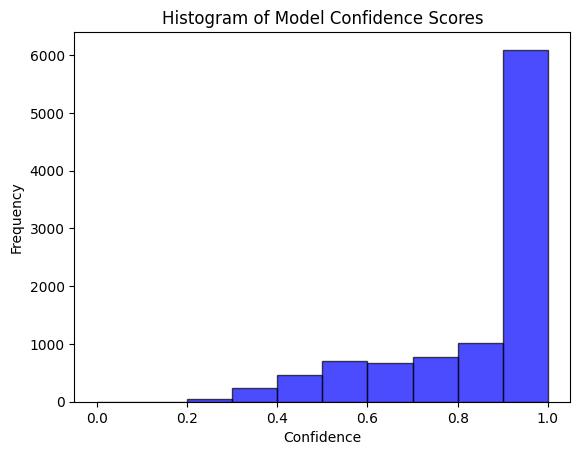

In [67]:
import matplotlib.pyplot as plt

plt.hist(test_confidences, bins=10, range=(0,1), alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.title("Histogram of Model Confidence Scores")
plt.show()


In [68]:
test_accuracy = np.mean(test_correct)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 81.04%


In [69]:
test_confidences = np.array(test_confidences)  # Ensure NumPy array
test_correct = np.array(test_correct)  # Ensure NumPy array

M = 10  # Number of bins
bin_boundaries = np.linspace(0, 1, M + 1)
bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2

bin_accs = []
bin_confs = []
for i in range(M):
    in_bin = (test_confidences >= bin_boundaries[i]) & (test_confidences < bin_boundaries[i + 1])
    
    if np.sum(in_bin) > 0:  # Only compute if the bin has samples
        bin_accs.append(np.mean(test_correct[in_bin]))  # Compute accuracy for samples in bin
        bin_confs.append(np.mean(test_confidences[in_bin]))  # Compute confidence for samples in bin
    else:
        bin_accs.append(0)
        bin_confs.append(0)


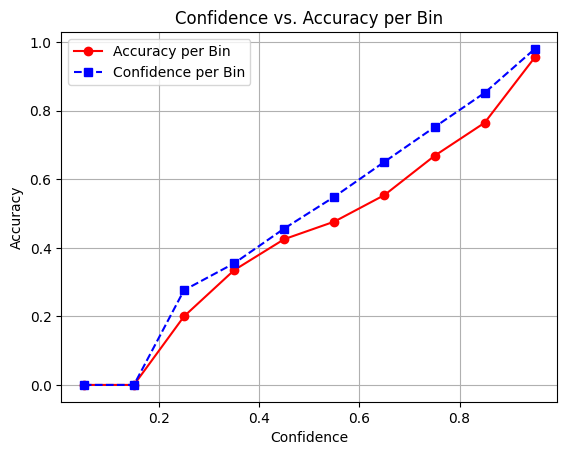

In [70]:
import matplotlib.pyplot as plt

plt.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Accuracy per Bin")
plt.plot(bin_centers, bin_confs, marker="s", linestyle="--", color="blue", label="Confidence per Bin")
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Confidence vs. Accuracy per Bin")
plt.legend()
plt.grid(True)
plt.show()


### **Calibration Methods for Multiclass Classification**
According to **Guo et al. (2017)**, different calibration methods perform differently in **binary vs. multiclass** settings:

 **Methods that work better for binary classification:**
- **Histogram Binning (HB)**: Designed for binary classification; does not naturally extend to multiclass settings.
- **Isotonic Regression (IR)**: Works well for binary classification but struggles with limited data in each bin for multiclass settings.
- **Bayesian Binning into Quantiles (BBQ)**: Also designed for binary classification; extending it to multiclass requires additional modifications.

 **Best methods for multiclass classification:**
- **Extended Binning methods (EHB)**: U can extend the binning methods of HB,IR and BBQ for multiclass.
- **Temperature Scaling (TS)**: The most effective and simplest method for deep neural networks. It **scales logits before softmax** using a learned temperature parameter.
- **Vector Scaling (VS)**: Extends TS by using a **per-class temperature**, allowing for more flexible adjustments.
- **Matrix Scaling (MS)**: The most complex, using a **full transformation matrix**, but requires more parameters and data to generalize well.


Thus our problem statement is multiclass and we use TS , VS and MS.


In [71]:
import torch.nn.functional as F

# Ensure model is in evaluation mode
model.eval()

# Function to extract logits and labels from a dataset
def extract_logits_and_labels(loader):
    logits_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            logits = model(images)  # Get raw logits
            logits_list.append(logits.cpu().numpy())  # Move to CPU for processing
            labels_list.append(labels.cpu().numpy())
    return np.vstack(logits_list), np.concatenate(labels_list)

val_logits, val_labels = extract_logits_and_labels(calib_loader)
test_logits, test_labels = extract_logits_and_labels(test_loader)

val_probs = F.softmax(torch.tensor(val_logits), dim=1).numpy()
test_probs = F.softmax(torch.tensor(test_logits), dim=1).numpy()


#  Extending Binary Calibration to Multiclass: A General Overview

##  **Why Extend Binary Calibration?**
- Calibration methods like **Histogram Binning, Isotonic Regression, and BBQ** were designed for **binary classification**.
- Multiclass classifiers (e.g., softmax outputs) require **a generalization of these methods**.

---

##  **General Approach: One-Versus-All (OVA) Calibration**
- Instead of calibrating softmax outputs directly, we **treat each class separately**.
- Each class is **converted into a binary calibration problem**:
  - True label **1** if the sample belongs to that class.
  - True label **0** otherwise.
- We train **K separate calibration models**, one per class.

---



# **Multiclass Histogram Binning Calibration**

- Instead of applying histogram binning to a single set of confidence scores (binary case), we apply it independently **for each class**.
- This effectively treats each class as a separate binary classification problem and then **re-normalizes** the calibrated probabilities to maintain a valid distribution.



In [86]:
import numpy as np

def calibrate_histogram_multiclass(val_probs, val_labels, M=10):
    """
    Perform histogram binning for each class separately in a multiclass setting.

    val_probs: (N, K) array of softmax probabilities.
    val_labels: (N,) array of true labels.
    M: Number of bins.
    """
    K = val_probs.shape[1]  # Number of classes
    bin_boundaries = np.zeros((K, M+1))
    bin_accs = np.zeros((K, M))

    for k in range(K):
        class_probs = val_probs[:, k]  # Extract class-specific probabilities
        correct = (val_labels == k).astype(int)  # Binary correctness for class k

        # Ensure inputs are numpy arrays
        class_probs = np.asarray(class_probs)
        correct = np.asarray(correct)

        # Sort validation data by confidence
        sorted_idx = np.argsort(class_probs)
        sorted_conf = class_probs[sorted_idx]
        sorted_corr = correct[sorted_idx]
        N = len(sorted_conf)

        bin_boundaries[k, 0] = 0.0
        for m in range(M):
            start_idx = int(m * N / M)
            end_idx = int((m+1) * N / M) if m < M-1 else N
            bin_conf = sorted_conf[start_idx:end_idx]
            bin_corr = sorted_corr[start_idx:end_idx]

            if len(bin_conf) == 0:
                bin_boundaries[k, m+1] = bin_boundaries[k, m]
                bin_accs[k, m] = bin_accs[k, m-1] if m > 0 else 0.0
            else:
                bin_boundaries[k, m+1] = bin_conf[-1]
                bin_accs[k, m] = np.mean(bin_corr)

        bin_boundaries[k, -1] = 1.0  # Ensure last boundary is 1.0

    # Function to apply histogram binning to test data
    def apply(test_probs):
        calibrated_probs = np.zeros_like(test_probs, dtype=float)

        for k in range(K):
            for i, p in enumerate(test_probs[:, k]):
                bin_idx = np.searchsorted(bin_boundaries[k], p, side='right') - 1
                bin_idx = max(0, min(bin_idx, M-1))  # Ensure valid bin index
                calibrated_probs[i, k] = bin_accs[k, bin_idx]

        # Renormalize probabilities so they sum to 1
        calibrated_probs /= np.sum(calibrated_probs, axis=1, keepdims=True)
        return calibrated_probs

    return apply


hist_calibrator_multiclass = calibrate_histogram_multiclass(val_probs, val_labels, M=10)

hist_calib_probs = hist_calibrator_multiclass(test_probs)

hist_ece, hist_mce = compute_ece_mce_multiclass(hist_calib_probs, test_labels, M=10)
print(f"Histogram Binning ECE: {hist_ece:.4f}, MCE: {hist_mce:.4f}")


Histogram Binning ECE: 0.0199, MCE: 0.2245


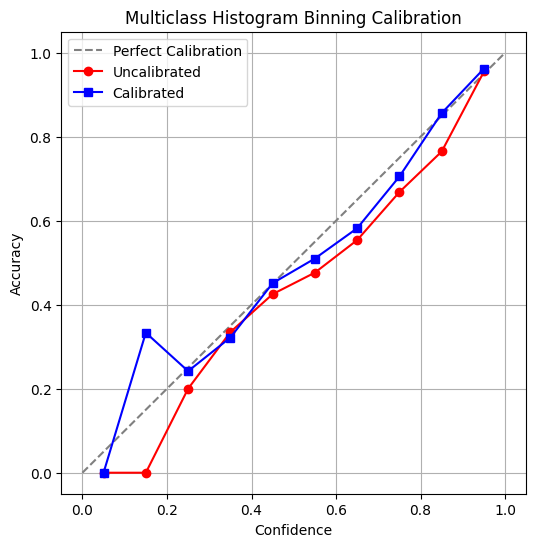

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram_multiclass(probs, labels, calibrated_probs=None, title="Multiclass Calibration", M=10):
    """
    Plot a reliability diagram for multiclass classification before and after calibration.

    probs: (N, K) array of softmax probabilities before calibration.
    labels: (N,) array of true labels.
    calibrated_probs: (N, K) array of softmax probabilities after calibration (optional).
    M: Number of bins.
    """
    confidences = np.max(probs, axis=1)  # Get highest predicted confidence per sample
    predictions = np.argmax(probs, axis=1)  # Get predicted classes
    correct = (predictions == labels).astype(int)  # Get binary correctness

    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_accs = []
    bin_counts = []

    for i in range(M):
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_counts.append(np.sum(in_bin))
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(correct[in_bin]))
        else:
            bin_accs.append(0)

    # Plot reliability diagram
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")  # Diagonal
    ax.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Uncalibrated")  # Before calibration

    if calibrated_probs is not None:
        calib_confidences = np.max(calibrated_probs, axis=1)
        bin_accs_calib = []

        for i in range(M):
            in_bin = (calib_confidences >= bin_boundaries[i]) & (calib_confidences < bin_boundaries[i + 1])
            if np.sum(in_bin) > 0:
                bin_accs_calib.append(np.mean(correct[in_bin]))
            else:
                bin_accs_calib.append(0)

        ax.plot(bin_centers, bin_accs_calib, marker="s", linestyle="-", color="blue", label="Calibrated")  # After calibration

    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()


plot_reliability_diagram_multiclass(
    test_probs,   # Uncalibrated test probabilities
    test_labels,  # True labels
    hist_calib_probs,  # Calibrated probabilities
    title="Multiclass Histogram Binning Calibration"
)


# **Mutliclass IsotonicRegression**


 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.192, 0.489)  1000     0.4049          0.3740     0.0309    
2     [0.489, 0.630)  1000     0.5610          0.5340     0.0270    
3     [0.630, 0.754)  1000     0.6946          0.6610     0.0336    
4     [0.754, 0.869)  1000     0.8120          0.7830     0.0290    
5     [0.869, 0.933)  1000     0.9066          0.8910     0.0156    
6     [0.933, 0.973)  1000     0.9566          0.9300     0.0266    
7     [0.973, 0.987)  997      0.9805          0.9589     0.0216    
8     [0.987, 0.995)  1003     0.9915          0.9850     0.0065    
9     [0.995, 1.000)  991      0.9978          0.9919     0.0058    
10    [1.000, 1.000)  0        0.0000          0.0000     0.0000    
Isotonic Regression ECE: 0.0197, MCE: 0.0336


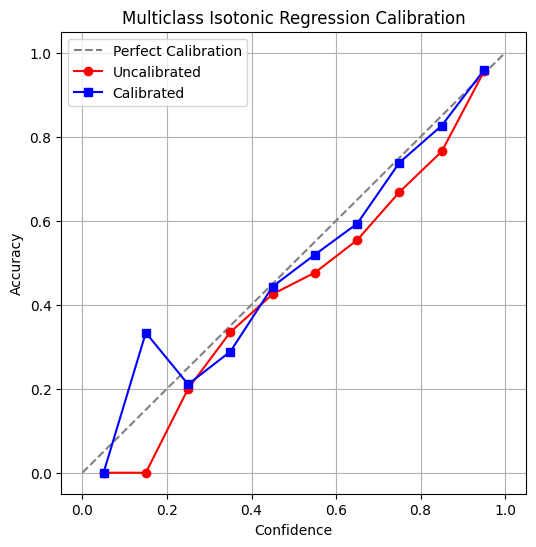

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

def calibrate_isotonic_multiclass(val_probs, val_labels):
    """
    Perform Isotonic Regression for each class separately in a multiclass setting.

    val_probs: Softmax probabilities (N, K)
    val_labels: Ground truth labels (N,)
    """
    K = val_probs.shape[1]  # Number of classes
    isotonic_models = [IsotonicRegression(y_min=0.0, y_max=1.0, out_of_bounds='clip') for _ in range(K)]

    # Train an isotonic regression model per class
    for k in range(K):
        class_probs = val_probs[:, k]  # Softmax probabilities for class k
        correct = (val_labels == k).astype(int)  # Binary correctness (1 if true class is k, else 0)

        # Fit isotonic regression model for class k
        isotonic_models[k].fit(class_probs, correct)

    # Function to apply isotonic calibration
    def apply(test_probs):
        calibrated_probs = np.zeros_like(test_probs, dtype=float)

        for k in range(K):
            calibrated_probs[:, k] = isotonic_models[k].predict(test_probs[:, k])

        # Renormalize to ensure probabilities sum to 1
        calibrated_probs /= np.sum(calibrated_probs, axis=1, keepdims=True)
        return calibrated_probs

    return apply

iso_calibrator_multiclass = calibrate_isotonic_multiclass(val_probs, val_labels)

iso_calib_probs = iso_calibrator_multiclass(test_probs)

iso_ece, iso_mce = compute_ece_fixed_bins(np.max(iso_calib_probs, axis=1), (np.argmax(test_probs, axis=1) == test_labels), M=10)
print(f"Isotonic Regression ECE: {iso_ece:.4f}, MCE: {iso_mce:.4f}")

def plot_reliability_diagram_multiclass(probs, labels, calibrated_probs=None, title="Multiclass Isotonic Regression Calibration", M=10):
    """
    Plot a reliability diagram for multiclass classification before and after calibration.

    probs: (N, K) array of softmax probabilities before calibration.
    labels: (N,) array of true labels.
    calibrated_probs: (N, K) array of softmax probabilities after calibration (optional).
    """
    confidences = np.max(probs, axis=1)  # Get highest predicted confidence per sample
    predictions = np.argmax(probs, axis=1)  # Get predicted classes
    correct = (predictions == labels).astype(int)  # Get binary correctness

    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_accs = []
    bin_counts = []

    # Compute accuracy per bin before calibration
    for i in range(M):
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_counts.append(np.sum(in_bin))
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(correct[in_bin]))
        else:
            bin_accs.append(0)

    # Plot reliability diagram
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")  # Diagonal
    ax.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Uncalibrated")  # Before calibration

    if calibrated_probs is not None:
        calib_confidences = np.max(calibrated_probs, axis=1)
        bin_accs_calib = []

        for i in range(M):
            in_bin = (calib_confidences >= bin_boundaries[i]) & (calib_confidences < bin_boundaries[i + 1])
            if np.sum(in_bin) > 0:
                bin_accs_calib.append(np.mean(correct[in_bin]))
            else:
                bin_accs_calib.append(0)

        ax.plot(bin_centers, bin_accs_calib, marker="s", linestyle="-", color="blue", label="Calibrated")  # After calibration

    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()

plot_reliability_diagram_multiclass(
    test_probs, 
    test_labels, 
    iso_calib_probs, 
    title="Multiclass Isotonic Regression Calibration"
)


# **Multiclass Bayesian Binning into Quantiles**

In [75]:
import numpy as np
from math import comb

def calibrate_bbq_multiclass(val_probs, val_labels, B_max=10):
    """
    Perform Bayesian Binning into Quantiles (BBQ) for each class separately in a multiclass setting.
    
    val_probs: Softmax probabilities (N, K)
    val_labels: Ground truth labels (N,)
    B_max: Maximum number of bins to consider
    """
    K = val_probs.shape[1]  # Number of classes
    models = []

    for k in range(K):
        class_probs = val_probs[:, k]  # Extract class k probabilities
        correct = (val_labels == k).astype(int)  # Binary correctness for class k

        # Ensure inputs are numpy arrays
        class_probs = np.asarray(class_probs)
        correct = np.asarray(correct)

        # Sort validation data by confidence
        sorted_idx = np.argsort(class_probs)
        sorted_conf = class_probs[sorted_idx]
        sorted_corr = correct[sorted_idx]
        N = len(sorted_conf)

        # Store bin accuracies for different bin counts
        class_models = []  # (bin_boundaries, bin_accs, bin_likelihood)

        for m in range(1, B_max + 1):
            bin_boundaries = []
            bin_accs = []
            likelihood = 1.0

            for j in range(m):
                start_idx = int(j * N / m)
                end_idx = int((j + 1) * N / m) if j < m - 1 else N
                conf_bin = sorted_conf[start_idx:end_idx]
                corr_bin = sorted_corr[start_idx:end_idx]
                n_bin = len(conf_bin)

                if n_bin == 0:
                    bin_boundaries.append(bin_boundaries[-1] if bin_boundaries else 0.0)
                    bin_accs.append(0.0)
                    continue
                
                bin_boundaries.append(conf_bin[-1])
                bin_accs.append(np.mean(corr_bin))  # Mean accuracy for this bin
                likelihood *= 1.0 / (n_bin + 1)  # Bayesian prior likelihood

            bin_boundaries[-1] = 1.0
            class_models.append((bin_boundaries, bin_accs, likelihood))

        # Normalize likelihoods to get posterior weights
        total_likelihood = sum(model[2] for model in class_models)
        for i, (bounds, accs, likelihood) in enumerate(class_models):
            weight = likelihood / total_likelihood
            class_models[i] = (bounds, accs, weight)

        models.append(class_models)

    # Function to apply BBQ calibration to test probabilities
    def apply(test_probs):
        test_probs = np.asarray(test_probs)
        calibrated_probs = np.zeros_like(test_probs)

        for k in range(K):
            class_models = models[k]
            for bounds, accs, weight in class_models:
                M = len(accs)
                bin_indices = np.searchsorted(bounds, test_probs[:, k], side='right') - 1
                bin_indices = np.clip(bin_indices, 0, M - 1)
                model_calib = np.array(accs)[bin_indices]
                calibrated_probs[:, k] += weight * model_calib

        # Renormalize probabilities
        calibrated_probs /= np.sum(calibrated_probs, axis=1, keepdims=True)
        return calibrated_probs

    return apply

bbq_calibrator_multiclass = calibrate_bbq_multiclass(val_probs, val_labels, B_max=10)

bbq_calib_probs = bbq_calibrator_multiclass(test_probs)

bbq_ece, bbq_mce = compute_ece_mce_multiclass(bbq_calib_probs, test_labels, M=10)
print(f"BBQ Calibration ECE: {bbq_ece:.4f}, MCE: {bbq_mce:.4f}")




BBQ Calibration ECE: 0.0078, MCE: 0.0078


# **Temperature Scaling**


**Equation:**  
$$
P(y_i) = \frac{e^{z_i / T}}{\sum_j e^{z_j / T}}
$$
where:
- \( z_i \) are logits (pre-softmax outputs).
- \( T \) is the learned **temperature parameter**.

**Why is it Better for Calibration?**  
 **Simple & Effective** – Uses only one parameter \( T \).  
 **Does Not Change Accuracy** – Only adjusts confidence scores.  
 **Reduces Overconfidence** – Softens overconfident predictions.  
 **Works Well for Deep Models** – Particularly effective in deep neural networks.

**Key Insight:**  
- \( T > 1 \) → **Softens** confidence (reduces overconfidence).  
- \( T < 1 \) → **Sharpens** confidence (rarely used).  


Optimal temperature: 1.203

 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.191, 0.489)  1000     0.4012          0.3940     0.0072    
2     [0.489, 0.619)  1000     0.5547          0.5250     0.0297    
3     [0.619, 0.745)  1000     0.6835          0.6620     0.0215    
4     [0.745, 0.851)  1000     0.7988          0.7800     0.0188    
5     [0.851, 0.918)  1000     0.8881          0.8830     0.0051    
6     [0.918, 0.960)  1000     0.9417          0.9340     0.0077    
7     [0.960, 0.982)  1000     0.9722          0.9530     0.0192    
8     [0.982, 0.993)  1000     0.9884          0.9820     0.0064    
9     [0.993, 0.998)  1000     0.9961          0.9920     0.0041    
10    [0.998, 1.000)  999      0.9993          0.9990     0.0003    
Temperature Scaling ECE: 0.0120, MCE: 0.0297


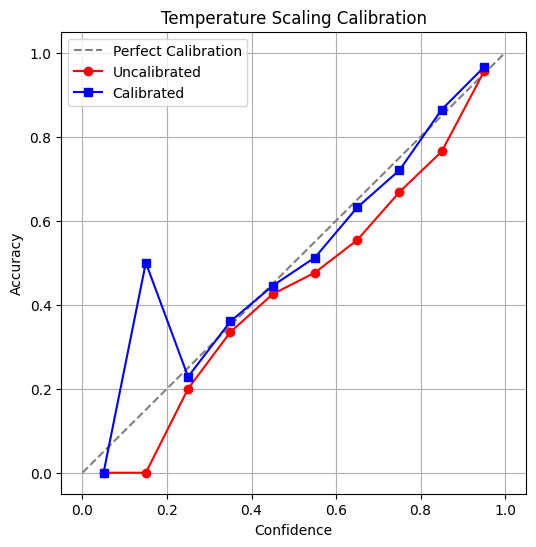

In [76]:
def calibrate_temperature(val_logits, val_labels):
    # Use PyTorch for gradient-based optimization of temperature
    logits_tensor = torch.tensor(val_logits, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)
    T = torch.tensor([2.0], dtype=torch.float32, device=device, requires_grad=True) 
    optimizer = optim.LBFGS([T], lr=0.5, max_iter=35)  

    def eval_loss():
        optimizer.zero_grad()
        # scaled logits
        scaled_logits = logits_tensor / T.clamp(min=1e-6)  # ensure T > 0
        loss = F.cross_entropy(scaled_logits, labels_tensor)
        loss.backward()
        return loss

    optimizer.step(eval_loss)
    T_opt = T.item()
    print(f"Optimal temperature: {T_opt:.3f}")
    # Function to apply temperature scaling to logits and get confidence
    def apply(logits):
        logits = torch.tensor(logits, dtype=torch.float32)
        probs = F.softmax(logits / T_opt, dim=1).numpy()
        # return the confidence of the predicted class
        return np.max(probs, axis=1)
    return apply, T_opt

# Fit temperature scaling on validation logits
temp_calibrator, temperature = calibrate_temperature(val_logits, val_labels)

# Extract logits from the test set (just like we did for validation set)
test_logits_list = []
test_labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)  # Extract logits
        test_logits_list.append(logits.cpu().numpy())
        test_labels_list.append(labels.numpy())

# Stack logits and labels
test_logits = np.vstack(test_logits_list)  # Shape: (N, num_classes)
test_labels = np.concatenate(test_labels_list)  # Shape: (N,)

# Apply temperature scaling using the learned temperature
temp_calib_conf = temp_calibrator(test_logits) 

# Compute ECE and MCE after temperature scaling
temp_ece, temp_mce = compute_ece_fixed_bins(temp_calib_conf, test_correct, M=10)
print(f"Temperature Scaling ECE: {temp_ece:.4f}, MCE: {temp_mce:.4f}")
def plot_reliability_diagram(confidences, correct, calibrated_confidences=None, title="Temperature Scaling Calibration"):
    """Plot Reliability Diagram (before and after calibration)"""
    M = 10  # Number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_accs = []
    bin_counts = []

    for i in range(M):
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_counts.append(np.sum(in_bin))
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(correct[in_bin]))
        else:
            bin_accs.append(0)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration") 
    ax.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Uncalibrated")  

    if calibrated_confidences is not None:
        bin_accs_calib = []
        for i in range(M):
            in_bin = (calibrated_confidences >= bin_boundaries[i]) & (calibrated_confidences < bin_boundaries[i + 1])
            if np.sum(in_bin) > 0:
                bin_accs_calib.append(np.mean(correct[in_bin]))
            else:
                bin_accs_calib.append(0)
        ax.plot(bin_centers, bin_accs_calib, marker="s", linestyle="-", color="blue", label="Calibrated")  # After calibration

    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()

# Plot reliability diagram for temperature scaling
plot_reliability_diagram(
    np.array(test_confidences),
    np.array(test_correct),
    np.array(temp_calib_conf),
    title="Temperature Scaling Calibration"
)



# **Vector Scaling**


**Equation:**  
$$
P(y_i) = \frac{e^{Wz_i + b}}{\sum_j e^{Wz_j + b}}
$$
where:
- \( W \) is a **learned diagonal matrix** (scales each logit differently).
- \( b \) is a **learned bias vector**.
- \( z_i \) are logits (pre-softmax outputs).

**Why is it Better for Calibration?**  
 **More Flexible than Temperature Scaling** – Learns different scaling factors for each class.  
 **Improves Calibration in Multi-Class Models** – Adapts to per-class confidence distributions.    

**Key Insight:**  
- Unlike Temperature Scaling, which uses a **single scalar \( T \)**, Vector Scaling **applies per-class transformations** for more precise calibration,but it is compuattionally bit more expensive  


In [77]:
def calibrate_vector(val_logits, val_labels):
    K = val_logits.shape[1]
    logits_tensor = torch.tensor(val_logits, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)
    # Initialize scale and bias
    scale = torch.ones(K, dtype=torch.float32, device=device, requires_grad=True)
    bias  = torch.zeros(K, dtype=torch.float32, device=device, requires_grad=True)
    optimizer = optim.LBFGS([scale, bias], lr=0.1, max_iter=100)

    def eval_loss_vec():
        optimizer.zero_grad()
        # apply diagonal scaling: new_logits[i,k] = scale_k * val_logits[i,k] + bias_k
        scaled_logits = logits_tensor * scale + bias
        loss = F.cross_entropy(scaled_logits, labels_tensor)
        loss.backward()
        return loss

    optimizer.step(eval_loss_vec)
    scale_opt = scale.detach().cpu().numpy()
    bias_opt = bias.detach().cpu().numpy()
    # Calibration function for new logits
    def apply(logits):
        # logits: numpy array shape (n_samples, K)
        logits = np.array(logits, dtype=np.float32)
        scaled = logits * scale_opt + bias_opt
        probs = softmax(scaled)  # we'll use a numpy softmax implementation
        return np.max(probs, axis=1)
    # Define a numpy softmax for convenience
    def softmax(z):
        z = z - np.max(z, axis=1, keepdims=True)  # for numerical stability
        expz = np.exp(z)
        return expz / np.sum(expz, axis=1, keepdims=True)
    return apply, scale_opt, bias_opt

# Fit vector scaling on validation logits
vector_calibrator, scale_vec, bias_vec = calibrate_vector(val_logits, val_labels)
# Apply to test logits
vector_calib_conf = vector_calibrator(test_logits)
vector_ece, vector_mce = compute_ece_fixed_bins(vector_calib_conf, test_correct, M=10)
print(f"Vector Scaling ECE: {vector_ece:.4f}, MCE: {vector_mce:.4f}")



 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.191, 0.496)  1000     0.4036          0.3540     0.0496    
2     [0.496, 0.626)  1000     0.5595          0.5330     0.0265    
3     [0.626, 0.755)  1000     0.6917          0.6590     0.0327    
4     [0.755, 0.858)  1000     0.8092          0.8060     0.0032    
5     [0.858, 0.928)  1000     0.8962          0.8790     0.0172    
6     [0.928, 0.965)  1000     0.9488          0.9330     0.0158    
7     [0.965, 0.986)  1000     0.9764          0.9620     0.0144    
8     [0.986, 0.995)  1000     0.9908          0.9860     0.0048    
9     [0.995, 0.999)  1000     0.9972          0.9930     0.0042    
10    [0.999, 1.000)  999      0.9995          0.9990     0.0005    
Vector Scaling ECE: 0.0169, MCE: 0.0496



 **ECE Bin Breakdown (Quantile Bins)**
Bin   Range                Count    Avg Confidence  Accuracy   Gap       
1     [0.201, 0.501)  1000     0.4082          0.3520     0.0562    
2     [0.501, 0.634)  1000     0.5654          0.5250     0.0404    
3     [0.634, 0.760)  1000     0.6979          0.6600     0.0379    
4     [0.760, 0.861)  1000     0.8140          0.8010     0.0130    
5     [0.861, 0.930)  1000     0.8982          0.8910     0.0072    
6     [0.930, 0.969)  1000     0.9514          0.9430     0.0084    
7     [0.969, 0.987)  1000     0.9790          0.9560     0.0230    
8     [0.987, 0.996)  1000     0.9922          0.9810     0.0112    
9     [0.996, 0.999)  1000     0.9978          0.9970     0.0008    
10    [0.999, 1.000)  999      0.9996          0.9980     0.0016    
Matrix Scaling ECE: 0.0200, MCE: 0.0562


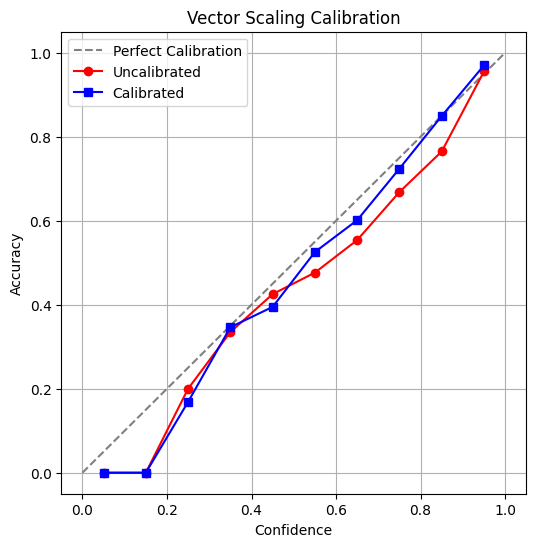

In [78]:
def calibrate_matrix(val_logits, val_labels):
    K = val_logits.shape[1]
    logits_tensor = torch.tensor(val_logits, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)
    # Initialize weight matrix and bias
    W = torch.eye(K, dtype=torch.float32, device=device, requires_grad=True)  # start as identity
    b = torch.zeros(K, dtype=torch.float32, device=device, requires_grad=True)
    optimizer = optim.LBFGS([W, b], lr=0.1, max_iter=100)

    def eval_loss_mat():
        optimizer.zero_grad()
        # W is KxK, logits_tensor is NxK -> output NxK
        scaled_logits = logits_tensor @ W.t() + b  # (apply linear transform)
        loss = F.cross_entropy(scaled_logits, labels_tensor)
        loss.backward()
        return loss

    optimizer.step(eval_loss_mat)
    W_opt = W.detach().cpu().numpy()
    b_opt = b.detach().cpu().numpy()
    # Calibration function
    def apply(logits):
        logits = np.array(logits, dtype=np.float32)
        scaled = logits.dot(W_opt.T) + b_opt
        # softmax and return max confidence
        expz = np.exp(scaled - np.max(scaled, axis=1, keepdims=True))
        probs = expz / np.sum(expz, axis=1, keepdims=True)
        return np.max(probs, axis=1)
    return apply, W_opt, b_opt

# Fit matrix scaling on validation logits
matrix_calibrator, W_mat, b_mat = calibrate_matrix(val_logits, val_labels)
# Apply to test logits
matrix_calib_conf = matrix_calibrator(test_logits)
matrix_ece, matrix_mce = compute_ece_fixed_bins(matrix_calib_conf, test_correct, M=10)
print(f"Matrix Scaling ECE: {matrix_ece:.4f}, MCE: {matrix_mce:.4f}")

def plot_reliability_diagram(confidences, correct, calibrated_confidences=None, title="Vector Scaling Calibration"):
    """Plot Reliability Diagram (before and after calibration)"""
    M = 10  # Number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_accs = []
    bin_counts = []

    for i in range(M):
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_counts.append(np.sum(in_bin))
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(correct[in_bin]))
        else:
            bin_accs.append(0)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")  # Diagonal
    ax.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Uncalibrated")  # Before calibration

    if calibrated_confidences is not None:
        bin_accs_calib = []
        for i in range(M):
            in_bin = (calibrated_confidences >= bin_boundaries[i]) & (calibrated_confidences < bin_boundaries[i + 1])
            if np.sum(in_bin) > 0:
                bin_accs_calib.append(np.mean(correct[in_bin]))
            else:
                bin_accs_calib.append(0)
        ax.plot(bin_centers, bin_accs_calib, marker="s", linestyle="-", color="blue", label="Calibrated")  # After calibration

    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()

# Plot reliability diagram for vector scaling
plot_reliability_diagram(
    np.array(test_confidences),
    np.array(test_correct),
    np.array(vector_calib_conf),
    title="Vector Scaling Calibration"
)


# **Matrix Scaling**

Matrix Scaling is an **advanced post-hoc calibration method** that extends Vector Scaling by using a **full learnable weight matrix \( W \) and bias \( b \)**, allowing more flexible transformations of the logits.

**Equation:**  
$$
P(y_i) = \frac{e^{Wz_i + b}}{\sum_j e^{Wz_j + b}}
$$
where:
- \( W \) is a **learned full weight matrix** (allows interactions between logits).
- \( b \) is a **learned bias vector**.
- \( z_i \) are logits (pre-softmax outputs).

**Why is it Better for Calibration?**  
 **More Expressive than Vector Scaling** – Accounts for correlations between logits.  
 **Improves Calibration in Complex Models** – Handles varying confidence distributions better.  



 Optimized Weight Matrix (W):
[[ 1.24324691e+00  2.12197110e-01  3.33253831e-01  3.43561739e-01
   3.38590831e-01  1.43453851e-01  3.40434223e-01  4.12538171e-01
   3.89889181e-01  3.92179877e-01]
 [ 4.65590805e-02  8.79748821e-01 -9.66810882e-02  1.70354947e-01
  -2.53332667e-02  4.98977164e-03  1.38114288e-03 -5.16498424e-02
   7.27878213e-02  1.36302374e-02]
 [-2.27016076e-01 -3.43386561e-01  5.44011593e-01 -4.33912426e-01
  -3.00688595e-01 -1.79370835e-01 -2.73552090e-01 -3.05793345e-01
  -2.88719207e-01 -3.99633199e-01]
 [ 2.87779067e-02  1.39495969e-01  4.34966274e-02  8.98026109e-01
   1.80343017e-01  1.22993059e-01  8.85352269e-02  4.06713299e-02
   8.37350786e-02  1.07161812e-01]
 [ 1.08372360e-01  1.69373915e-01  1.10321686e-01  1.28436446e-01
   1.01852417e+00  2.52812535e-01  1.87844068e-01  1.28330156e-01
   2.33934119e-01  1.59588248e-01]
 [ 1.72738254e-01  2.53854990e-01  2.54214346e-01  2.88004696e-01
   1.95374906e-01  1.01266801e+00  1.65069014e-01  1.58312336e-01
   

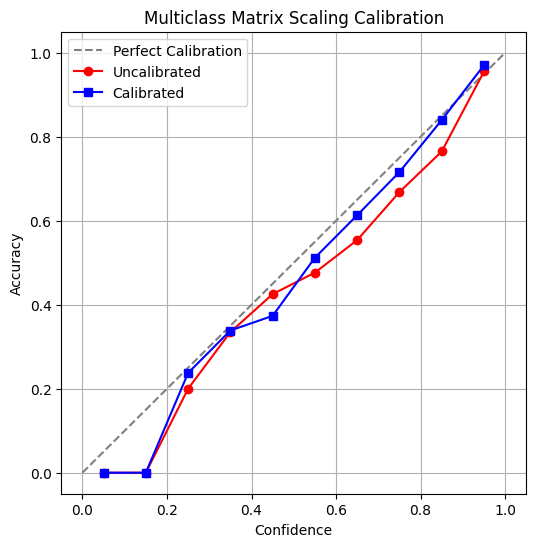

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F

def calibrate_matrix(val_logits, val_labels):
    """Optimize matrix scaling using validation logits and labels."""
    K = val_logits.shape[1]  # Number of classes
    logits_tensor = torch.tensor(val_logits, dtype=torch.float32, device=device)
    labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)  # 

    # Initialize weight matrix (W) and bias (b)
    W = torch.eye(K, dtype=torch.float32, device=device, requires_grad=True)  # Identity matrix init
    b = torch.zeros(K, dtype=torch.float32, device=device, requires_grad=True)  # Zero bias

    optimizer = optim.LBFGS([W, b], lr=0.1, max_iter=100)

    def eval_loss_mat():
        optimizer.zero_grad()
        scaled_logits = logits_tensor @ W.t() + b  # Apply learned transformation
        loss = F.cross_entropy(scaled_logits, labels_tensor)
        loss.backward()
        return loss

    optimizer.step(eval_loss_mat)
    W_opt = W.detach().cpu().numpy()
    b_opt = b.detach().cpu().numpy()
    print(f" Optimized Weight Matrix (W):\n{W_opt}\n Optimized Bias (b): {b_opt}")

    # Define calibration function
    def apply(logits):
        logits = np.array(logits, dtype=np.float32)
        scaled = logits.dot(W_opt.T) + b_opt  # Apply learned transformation
        probs = np.exp(scaled - np.max(scaled, axis=1, keepdims=True))  # Softmax calculation
        probs /= np.sum(probs, axis=1, keepdims=True)
        return probs  

    return apply, W_opt, b_opt

matrix_calibrator, W_mat, b_mat = calibrate_matrix(val_logits, val_labels)

matrix_calib_probs = matrix_calibrator(test_logits) 

matrix_ece, matrix_mce = compute_ece_mce_multiclass(matrix_calib_probs, test_labels, M=10)
print(f" Matrix Scaling ECE: {matrix_ece:.4f}, MCE: {matrix_mce:.4f}")

# 🔹 Reliability Diagram for Matrix Scaling
def plot_reliability_diagram_multiclass(probs, labels, calibrated_probs=None, title="Matrix Scaling Calibration", M=10):
    """Plot Reliability Diagram for Multiclass Matrix Scaling."""
    confidences = np.max(probs, axis=1)  
    predictions = np.argmax(probs, axis=1) 
    correct = (predictions == labels).astype(int)  

    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    bin_accs = []
    bin_counts = []

    # Compute accuracy per bin before calibration
    for i in range(M):
        in_bin = (confidences >= bin_boundaries[i]) & (confidences < bin_boundaries[i + 1])
        bin_counts.append(np.sum(in_bin))
        if np.sum(in_bin) > 0:
            bin_accs.append(np.mean(correct[in_bin]))
        else:
            bin_accs.append(0)

    # Plot reliability diagram
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect Calibration")  # Diagonal
    ax.plot(bin_centers, bin_accs, marker="o", linestyle="-", color="red", label="Uncalibrated")  # Before calibration

    if calibrated_probs is not None:
        calib_confidences = np.max(calibrated_probs, axis=1)
        bin_accs_calib = []

        for i in range(M):
            in_bin = (calib_confidences >= bin_boundaries[i]) & (calib_confidences < bin_boundaries[i + 1])
            if np.sum(in_bin) > 0:
                bin_accs_calib.append(np.mean(correct[in_bin]))
            else:
                bin_accs_calib.append(0)

        ax.plot(bin_centers, bin_accs_calib, marker="s", linestyle="-", color="blue", label="Calibrated")  # After calibration

    ax.set_xlabel("Confidence")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)
    ax.legend()
    plt.grid(True)
    plt.show()

plot_reliability_diagram_multiclass(
    test_probs, 
    test_labels, 
    matrix_calib_probs, 
    title="Multiclass Matrix Scaling Calibration"
)


In [83]:
methods = [
    "Uncalibrated", 
    "Temperature Scaling", 
    "Vector Scaling", 
    "Matrix Scaling", 
    "BBQ (Bayesian Binning into Quantiles)", 
    "Histogram Binning", 
    "Multiclass Isotonic Regression"
]

ece_values = [
    uncalib_ece, 
    temp_ece, 
    vector_ece, 
    matrix_ece, 
    bbq_ece, 
    hist_ece, 
    iso_ece
]

mce_values = [
    uncalib_mce, 
    temp_mce, 
    vector_mce, 
    matrix_mce, 
    bbq_mce, 
    hist_mce, 
    iso_mce
]

print("\n **ECE & MCE Results for All Calibration Methods**")
print("=" * 65)
print(f"{'Method':30s} | {'ECE (%)':10s} | {'MCE (%)':10s}")
print("-" * 65)

for method, ece, mce in zip(methods, ece_values, mce_values):
    print(f"{method:30s} | {ece:.3%}     | {mce:.3%}")

print("=" * 65)



 **ECE & MCE Results for All Calibration Methods**
Method                         | ECE (%)    | MCE (%)   
-----------------------------------------------------------------
Uncalibrated                   | 4.438%     | 9.634%
Temperature Scaling            | 1.200%     | 2.971%
Vector Scaling                 | 1.689%     | 4.961%
Matrix Scaling                 | 1.397%     | 4.694%
BBQ (Bayesian Binning into Quantiles) | 0.780%     | 0.780%
Histogram Binning              | 1.988%     | 22.449%
Multiclass Isotonic Regression | 1.966%     | 3.356%


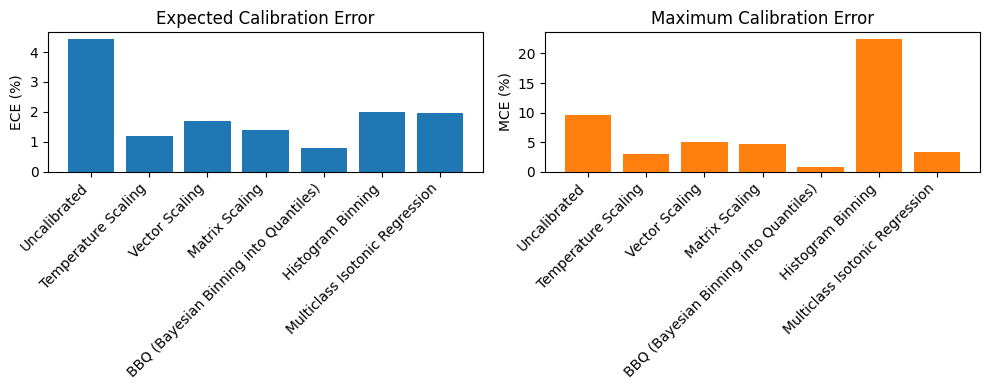

In [84]:
# Bar plot for ECE and MCE
x = np.arange(len(methods))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.bar(x, [e*100 for e in ece_values], color="C0")
ax1.set_xticks(x); ax1.set_xticklabels(methods, rotation=45, ha="right")
ax1.set_ylabel("ECE (%)")
ax1.set_title("Expected Calibration Error")

ax2.bar(x, [m*100 for m in mce_values], color="C1")
ax2.set_xticks(x); ax2.set_xticklabels(methods, rotation=45, ha="right")
ax2.set_ylabel("MCE (%)")
ax2.set_title("Maximum Calibration Error")
plt.tight_layout()
plt.show()
